<a href="https://colab.research.google.com/github/tuphr2234/ChaosPredition/blob/main/ThreeBodySimulation_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build Simulation

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import os
from pathlib import Path  


G=1


class Body:
  
  prevPosition=np.array([0,0])
  position=np.array([0,0])
  velocity=np.array([0,0])
  force=np.array([0,0])
  acceleration=np.array([0,0])
  mass=0

  def __init__(self,position,velocity,mass,name):
    self.position=np.array(position)
    self.velocity=np.array(velocity)
    #self.acceleration=np.array(acceleration)
    self.mass=mass
    self.prevPosition=np.array(position)
    self.name = name


  def setPosition(self,t):
    self.prevPosition = self.position
    self.position=self.position+self.velocity*t+(self.acceleration/2)* t**2
  
    


  def setVelocity(self,t):
    self.velocity=self.velocity+self.acceleration*t
  

  def getForce(self,body):
    softening = 0.00001
    Distance = body.prevPosition - self.position
    Rsquare = Distance[0]**2 + Distance[1]**2 + softening
    F = G* self.mass*body.mass / Rsquare  
    normalizeDis = Distance / math.sqrt(Rsquare)
    F = F*normalizeDis
    
    #print(f"body {self.name} force is {F} ")
    
    return F

  def setAcceleration(self,bodies):
    F=np.array([0,0])
    for body in bodies:
      F=F+self.getForce(body)
    self.acceleration = F/self.mass
   # print(f" {self.name} acceleration is {self.acceleration}")

In [2]:
def simulateOnTimeStep(bodies,t,steps,interval_in_data): # bodies: list of bodies. t: timestep . steps: number of steps. interval_in_data : frequency of rows taken to dataset: if equals 1 than it is every step
  dataset = []
  time = []

  for i in range(steps):
      list1=[]
      for body in bodies:
        list1.append(body.position)
      if i % interval_in_data ==0:
        dataset += list1
        time.append(i * t)
      
      for i,body in enumerate(bodies):
        body.setAcceleration([b for b in bodies if b is not body])
        body.setVelocity(t)
        body.setPosition(t)
       
        
      for body in bodies:
        #plt.plot([body.prevPosition[0],body.position[0]],[body.prevPosition[1],body.position[1]])
        body.prevPosition = body.position
  #plt.show()
    

  return np.array(dataset).reshape(steps//interval_in_data,len(bodies),2),time



In [3]:
def numpyToPandas(simulation,numOfBodies):
  columns = []

  for i in range(numOfBodies):
    columns.append(f'Body{i+1} x')
    columns.append(f'Body{i+1} y')
  simulation_reshaped = simulation.reshape(len(simulation), numOfBodies*2 )

  df = pd.DataFrame(simulation_reshaped, columns = columns)
  return df


Add Filters

In [4]:
#def addNoise(simulation):
#def removeBody(simulation)

Save Simulation

In [5]:
## save simulation as csv
def saveSimulation(simulation,numOfBodies,simulation_name):
  df = numpyToPandas(simulation,numOfBodies) 
  df.to_csv(f'/content/{simulation_name}.csv',index=False)
  
def loadSimulation(df):
  return pd.DataFrame.to_numpy(df)  

Prepare Dataset 

In [6]:
def prepareData(simulation,window_size_X):
  X = []
  y = []
  for i in range(len(simulation)-window_size_X):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  ### adding time is an option
    X.append(row)
    label = simulation[i+window_size_X]
    y.append(label)
  return np.array(X) , np.array(y)  

In [34]:
def prepareData2(simulation,window_size_X,window_size_y): 
  X = []
  y = []
  for i in range(len(simulation)-window_size_X - window_size_y):
    row = [bodies for bodies in simulation[i:i+window_size_X]]  
    X.append(row)
    label =  [bodies for bodies in simulation[i+window_size_X:i+window_size_X + window_size_y]]#######################################
    y.append(label)

  return np.array(X) , np.array(y)


In [8]:
def splitToTrainValidTest(dataset,testPercentage):
  trainLen = round((len(dataset)*(1-testPercentage-0.05)))
  valLen = round((len(dataset)*0.05))
  train_set = dataset[:trainLen]
  val_set = dataset[trainLen:trainLen+valLen]
  test_set = dataset[trainLen+valLen:]
  return train_set,val_set,test_set

In [9]:
def drawSimulation(simulation):
  prev = simulation[0]
  numOfBodies = len(simulation[0])

  for i,sim in enumerate(simulation):
    for j in range(0,len(sim),2):
      plt.plot([prev[j],sim[j]],[prev[j+1],sim[j+1]])
      prev[j] = sim[j]
      prev[j+1] = sim[j+1]
  plt.show()
  #plt.clf()


In [10]:
def showBodiesMovmentInGraph(simulation,trueForX):
 arr = []
 for i in range(0,len(simulation),2):
    for sim in simulation:
      arr.append(sim[i])


 plt.plot(arr)

Preprocessing/Postprocessing

Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
def buildModelCNN(window_size_X,numberOfBodies): ### One step at a time - autoreggresive model 
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  model.add(Conv1D(64, kernel_size=2))
  #model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2))
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(numberOfBodies*2, 'linear'))
  model.summary()
  return model



def buildModelCNN2(window_size_X,window_size_y,numberOfBodies): ### Multiple predictions at a time
  model = Sequential()
  model.add(InputLayer((window_size_X,numberOfBodies*2)))#model.add(InputLayer((window_size_X,numberOfBodies*2)))
  model.add(Conv1D(64, kernel_size=2)) ###
  #model.add(Dropout(0.2))
  model.add(Conv1D(32, kernel_size=2)) ###
  #model.add(TimeDistributed(conv_1d))
  model.add(Flatten())
  #model.add(LSTM(32))
  #model.add(Dropout(0.2))
  model.add(Dense(16, 'relu'))
  model.add(Dense(units =  window_size_y*numberOfBodies*2, activation ='linear'))
  model.add(tf.keras.layers.Reshape([window_size_y, numberOfBodies*2]))
  model.summary()
  return model

In [12]:
def preprocessSimulation(simulation):
  shape = simulation[0].shape
  newSimulation = np.append(simulation[1:],[np.zeros(shape)],axis=0) - simulation
  newSimulation = newSimulation[:-1]
  #for i,s in enumerate(newSimulation):
  #  s = s / np.linalg.norm(simulation[i])
  return newSimulation

In [13]:
def postprocess(lastKnownElement , listOfPredictedChanges):
  listOfPredictions = []
  for pred in listOfPredictedChanges:
    #newElement = (pred * np.linalg.norm(lastKnownElement)) + lastKnownElement
    newElement = pred  + lastKnownElement
    listOfPredictions.append(newElement)
    lastKnownElement = newElement
  return np.array(listOfPredictions)  


Training Model

In [14]:
#position,velocity,mass
#%%timeit
bodies=[]
bodies.append(Body([-0.97000436, 0.24308753],[0.4662036850, 0.4323657300],1,"body1"))
bodies.append(Body([0,0],[-0.93240737, -0.86473146],1,"body2"))
bodies.append(Body([0.97000436, -0.24308753],[0.4662036850, 0.4323657300],1,"body3"))
#bodies.append(Body([2, -0.24308753],[-0.4662036850, 0.4323657300],1,"body4"))

 #r1(0) = −r3(0) = (−0.97000436, 0.24308753);
 # r2(0) = (0,0); v1(0) = v3(0) = (0.4662036850, 0.4323657300);
 # v2(0) = (−0.93240737, −0.86473146). The values are obtained from Chenciner & Montgomery (2000).

numOfBodies=len(bodies)
##t: timestep . steps: number of steps. interval_in_data
timestep = 0.001 # actual seconds
steps = 122000
interval_in_data = 10

simulation1,timesteps = simulateOnTimeStep(bodies,timestep,steps,interval_in_data)
simulation1=simulation1.reshape(len(simulation1), numOfBodies*2 )
saveSimulation(simulation1,numOfBodies,"N-Body Simulation")

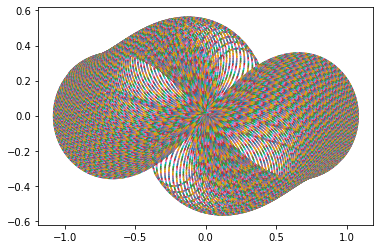

In [74]:
drawSimulation(simulation1)

In [16]:
simulation1 = loadSimulation(pd.read_csv('/content/N-Body Simulation.csv'))

In [17]:
numOfBodies = simulation1.shape[1] // 2

In [56]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.signal import hilbert
scaled = False 

#batch = 6

diffSimulation1 = np.diff(simulation1,axis = 0)

train, val, test = splitToTrainValidTest(diffSimulation1,0.2)


windowSizeX= len(val)*2
windowSizeY = len(val)




if scaled:
  scaler = StandardScaler()
  scaler.fit(simulation1[:len(train)+len(val)])
  #valScaler.fit(train)  ### train / val as input ? 

  train = scaler.transform(train)
  val = scaler.transform(val)
  #train = hilbert(train)
  #val = hilbert(val)
#y_train = scaler.fit(train)

#train = preprocessSimulation(train)
#val = preprocessSimulation(val)



#train2, val2, test2 = splitToTrainValidTest(simulation2,0.2)


#X_train, y_train = prepareData(train,windowSizeX)
#X_val, y_val = prepareData(val,windowSizeX)
#X_test, y_test = prepareData(test,windowSizeX)


X_train, y_train = prepareData2(train,windowSizeX,windowSizeY)
X_val, y_val = prepareData2(val,windowSizeX,windowSizeY)
X_test, y_test = prepareData2(test,windowSizeX,windowSizeY)


model =  buildModelCNN2(windowSizeX,windowSizeY,numOfBodies)
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])


#X_train2, y_train2 = prepareData(train2,windowSizeX)
#X_val2, y_val2 = prepareData(val2,windowSizeX)
#X_tes2t, y_test2 = prepareData(test2,windowSizeX)

#generator = TimeseriesGenerator(train_scaled,train_scaled,length = len(test),batch_size=batch)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1219, 64)          832       
                                                                 
 conv1d_5 (Conv1D)           (None, 1218, 32)          4128      
                                                                 
 flatten_2 (Flatten)         (None, 38976)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                623632    
                                                                 
 dense_5 (Dense)             (None, 3660)              62220     
                                                                 
 reshape_2 (Reshape)         (None, 610, 6)            0         
                                                                 
Total params: 690,812
Trainable params: 690,812
Non-tr

In [66]:
#for i in range(100):
  #model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, callbacks=[cp1])
  #model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=2, callbacks=[cp1])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/100
229/229 [==============================] - ETA: 0s - loss: 2.6399e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.6399e-06 - root_mean_squared_error: 0.0016
Epoch 2/100
229/229 [==============================] - ETA: 0s - loss: 2.6049e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.6049e-06 - root_mean_squared_error: 0.0016
Epoch 3/100
228/229 [============================>.] - ETA: 0s - loss: 2.5866e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 2.5868e-06 - root_mean_squared_error: 0.0016
Epoch 4/100
228/229 [============================>.] - ETA: 0s - loss: 2.5848e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.5850e-06 - root_mean_squared_error: 0.0016
Epoch 5/100
229/229 [==============================] - ETA: 0s - loss: 2.5613e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.5613e-06 - root_mean_squared_error: 0.0016
Epoch 6/100
229/229 [==============================] - ETA: 0s - loss: 2.5448e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.5448e-06 - root_mean_squared_error: 0.0016
Epoch 7/100
228/229 [============================>.] - ETA: 0s - loss: 2.5448e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 17s 72ms/step - loss: 2.5449e-06 - root_mean_squared_error: 0.0016
Epoch 8/100
228/229 [============================>.] - ETA: 0s - loss: 2.5160e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.5168e-06 - root_mean_squared_error: 0.0016
Epoch 9/100
229/229 [==============================] - ETA: 0s - loss: 2.4938e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.4938e-06 - root_mean_squared_error: 0.0016
Epoch 10/100
228/229 [============================>.] - ETA: 0s - loss: 2.4942e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.4953e-06 - root_mean_squared_error: 0.0016
Epoch 11/100
229/229 [==============================] - ETA: 0s - loss: 2.4563e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.4563e-06 - root_mean_squared_error: 0.0016
Epoch 12/100
229/229 [==============================] - ETA: 0s - loss: 2.4495e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.4495e-06 - root_mean_squared_error: 0.0016
Epoch 13/100
228/229 [============================>.] - ETA: 0s - loss: 2.4285e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.4290e-06 - root_mean_squared_error: 0.0016
Epoch 14/100
229/229 [==============================] - ETA: 0s - loss: 2.4396e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.4396e-06 - root_mean_squared_error: 0.0016
Epoch 15/100
229/229 [==============================] - ETA: 0s - loss: 2.3966e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 17s 72ms/step - loss: 2.3966e-06 - root_mean_squared_error: 0.0015
Epoch 16/100
229/229 [==============================] - ETA: 0s - loss: 2.4028e-06 - root_mean_squared_error: 0.0016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.4028e-06 - root_mean_squared_error: 0.0016
Epoch 17/100
229/229 [==============================] - ETA: 0s - loss: 2.3774e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.3774e-06 - root_mean_squared_error: 0.0015
Epoch 18/100
228/229 [============================>.] - ETA: 0s - loss: 2.3674e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.3674e-06 - root_mean_squared_error: 0.0015
Epoch 19/100
229/229 [==============================] - ETA: 0s - loss: 2.3602e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.3602e-06 - root_mean_squared_error: 0.0015
Epoch 20/100
228/229 [============================>.] - ETA: 0s - loss: 2.3447e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 64ms/step - loss: 2.3452e-06 - root_mean_squared_error: 0.0015
Epoch 21/100
228/229 [============================>.] - ETA: 0s - loss: 2.3362e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.3366e-06 - root_mean_squared_error: 0.0015
Epoch 22/100
229/229 [==============================] - ETA: 0s - loss: 2.3021e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.3021e-06 - root_mean_squared_error: 0.0015
Epoch 23/100
229/229 [==============================] - ETA: 0s - loss: 2.3129e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 2.3129e-06 - root_mean_squared_error: 0.0015
Epoch 24/100
229/229 [==============================] - ETA: 0s - loss: 2.3059e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 71ms/step - loss: 2.3059e-06 - root_mean_squared_error: 0.0015
Epoch 25/100
229/229 [==============================] - ETA: 0s - loss: 2.2693e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.2693e-06 - root_mean_squared_error: 0.0015
Epoch 26/100
228/229 [============================>.] - ETA: 0s - loss: 2.2616e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.2609e-06 - root_mean_squared_error: 0.0015
Epoch 27/100
228/229 [============================>.] - ETA: 0s - loss: 2.2472e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.2473e-06 - root_mean_squared_error: 0.0015
Epoch 28/100
229/229 [==============================] - ETA: 0s - loss: 2.2483e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.2483e-06 - root_mean_squared_error: 0.0015
Epoch 29/100
228/229 [============================>.] - ETA: 0s - loss: 2.2393e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.2394e-06 - root_mean_squared_error: 0.0015
Epoch 30/100
228/229 [============================>.] - ETA: 0s - loss: 2.2134e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.2136e-06 - root_mean_squared_error: 0.0015
Epoch 31/100
229/229 [==============================] - ETA: 0s - loss: 2.1936e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.1936e-06 - root_mean_squared_error: 0.0015
Epoch 32/100
229/229 [==============================] - ETA: 0s - loss: 2.2007e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 71ms/step - loss: 2.2007e-06 - root_mean_squared_error: 0.0015
Epoch 33/100
228/229 [============================>.] - ETA: 0s - loss: 2.1798e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.1795e-06 - root_mean_squared_error: 0.0015
Epoch 34/100
228/229 [============================>.] - ETA: 0s - loss: 2.2080e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.2078e-06 - root_mean_squared_error: 0.0015
Epoch 35/100
228/229 [============================>.] - ETA: 0s - loss: 2.1554e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.1546e-06 - root_mean_squared_error: 0.0015
Epoch 36/100
228/229 [============================>.] - ETA: 0s - loss: 2.1615e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.1617e-06 - root_mean_squared_error: 0.0015
Epoch 37/100
229/229 [==============================] - ETA: 0s - loss: 2.1462e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 71ms/step - loss: 2.1462e-06 - root_mean_squared_error: 0.0015
Epoch 38/100
229/229 [==============================] - ETA: 0s - loss: 2.1465e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.1465e-06 - root_mean_squared_error: 0.0015
Epoch 39/100
229/229 [==============================] - ETA: 0s - loss: 2.1343e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.1343e-06 - root_mean_squared_error: 0.0015
Epoch 40/100
229/229 [==============================] - ETA: 0s - loss: 2.1379e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 71ms/step - loss: 2.1379e-06 - root_mean_squared_error: 0.0015
Epoch 41/100
229/229 [==============================] - ETA: 0s - loss: 2.1335e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 2.1335e-06 - root_mean_squared_error: 0.0015
Epoch 42/100
228/229 [============================>.] - ETA: 0s - loss: 2.1170e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.1176e-06 - root_mean_squared_error: 0.0015
Epoch 43/100
228/229 [============================>.] - ETA: 0s - loss: 2.1084e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.1085e-06 - root_mean_squared_error: 0.0015
Epoch 44/100
228/229 [============================>.] - ETA: 0s - loss: 2.1039e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 14s 63ms/step - loss: 2.1047e-06 - root_mean_squared_error: 0.0015
Epoch 45/100
229/229 [==============================] - ETA: 0s - loss: 2.1069e-06 - root_mean_squared_error: 0.0015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.1069e-06 - root_mean_squared_error: 0.0015
Epoch 46/100
228/229 [============================>.] - ETA: 0s - loss: 2.0852e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.0846e-06 - root_mean_squared_error: 0.0014
Epoch 47/100
229/229 [==============================] - ETA: 0s - loss: 2.0763e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 2.0763e-06 - root_mean_squared_error: 0.0014
Epoch 48/100
229/229 [==============================] - ETA: 0s - loss: 2.0793e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 2.0793e-06 - root_mean_squared_error: 0.0014
Epoch 49/100
228/229 [============================>.] - ETA: 0s - loss: 2.0694e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.0695e-06 - root_mean_squared_error: 0.0014
Epoch 50/100
229/229 [==============================] - ETA: 0s - loss: 2.0560e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.0560e-06 - root_mean_squared_error: 0.0014
Epoch 51/100
229/229 [==============================] - ETA: 0s - loss: 2.0473e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 2.0473e-06 - root_mean_squared_error: 0.0014
Epoch 52/100
228/229 [============================>.] - ETA: 0s - loss: 2.0525e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.0524e-06 - root_mean_squared_error: 0.0014
Epoch 53/100
229/229 [==============================] - ETA: 0s - loss: 2.0436e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.0436e-06 - root_mean_squared_error: 0.0014
Epoch 54/100
229/229 [==============================] - ETA: 0s - loss: 2.0361e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.0361e-06 - root_mean_squared_error: 0.0014
Epoch 55/100
228/229 [============================>.] - ETA: 0s - loss: 2.0262e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.0264e-06 - root_mean_squared_error: 0.0014
Epoch 56/100
228/229 [============================>.] - ETA: 0s - loss: 2.0173e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.0177e-06 - root_mean_squared_error: 0.0014
Epoch 57/100
229/229 [==============================] - ETA: 0s - loss: 2.0309e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 2.0309e-06 - root_mean_squared_error: 0.0014
Epoch 58/100
228/229 [============================>.] - ETA: 0s - loss: 2.0178e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 17s 73ms/step - loss: 2.0172e-06 - root_mean_squared_error: 0.0014
Epoch 59/100
229/229 [==============================] - ETA: 0s - loss: 2.0264e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.0264e-06 - root_mean_squared_error: 0.0014
Epoch 60/100
229/229 [==============================] - ETA: 0s - loss: 2.0099e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 2.0099e-06 - root_mean_squared_error: 0.0014
Epoch 61/100
228/229 [============================>.] - ETA: 0s - loss: 2.0093e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 2.0092e-06 - root_mean_squared_error: 0.0014
Epoch 62/100
228/229 [============================>.] - ETA: 0s - loss: 1.9877e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.9880e-06 - root_mean_squared_error: 0.0014
Epoch 63/100
229/229 [==============================] - ETA: 0s - loss: 1.9936e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 1.9936e-06 - root_mean_squared_error: 0.0014
Epoch 64/100
228/229 [============================>.] - ETA: 0s - loss: 1.9795e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 1.9798e-06 - root_mean_squared_error: 0.0014
Epoch 65/100
228/229 [============================>.] - ETA: 0s - loss: 1.9650e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.9660e-06 - root_mean_squared_error: 0.0014
Epoch 66/100
228/229 [============================>.] - ETA: 0s - loss: 1.9784e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.9779e-06 - root_mean_squared_error: 0.0014
Epoch 67/100
228/229 [============================>.] - ETA: 0s - loss: 1.9693e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 1.9698e-06 - root_mean_squared_error: 0.0014
Epoch 68/100
229/229 [==============================] - ETA: 0s - loss: 1.9728e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.9728e-06 - root_mean_squared_error: 0.0014
Epoch 69/100
229/229 [==============================] - ETA: 0s - loss: 1.9484e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 1.9484e-06 - root_mean_squared_error: 0.0014
Epoch 70/100
228/229 [============================>.] - ETA: 0s - loss: 1.9527e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.9522e-06 - root_mean_squared_error: 0.0014
Epoch 71/100
228/229 [============================>.] - ETA: 0s - loss: 1.9633e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.9631e-06 - root_mean_squared_error: 0.0014
Epoch 72/100
229/229 [==============================] - ETA: 0s - loss: 1.9584e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.9584e-06 - root_mean_squared_error: 0.0014
Epoch 73/100
229/229 [==============================] - ETA: 0s - loss: 1.9491e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.9491e-06 - root_mean_squared_error: 0.0014
Epoch 74/100
228/229 [============================>.] - ETA: 0s - loss: 1.9514e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.9504e-06 - root_mean_squared_error: 0.0014
Epoch 75/100
229/229 [==============================] - ETA: 0s - loss: 1.9379e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 71ms/step - loss: 1.9379e-06 - root_mean_squared_error: 0.0014
Epoch 76/100
228/229 [============================>.] - ETA: 0s - loss: 1.9377e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.9380e-06 - root_mean_squared_error: 0.0014
Epoch 77/100
229/229 [==============================] - ETA: 0s - loss: 1.9406e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.9406e-06 - root_mean_squared_error: 0.0014
Epoch 78/100
229/229 [==============================] - ETA: 0s - loss: 1.9176e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 1.9176e-06 - root_mean_squared_error: 0.0014
Epoch 79/100
229/229 [==============================] - ETA: 0s - loss: 1.9380e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.9380e-06 - root_mean_squared_error: 0.0014
Epoch 80/100
228/229 [============================>.] - ETA: 0s - loss: 1.9178e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 1.9180e-06 - root_mean_squared_error: 0.0014
Epoch 81/100
228/229 [============================>.] - ETA: 0s - loss: 1.9015e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.9013e-06 - root_mean_squared_error: 0.0014
Epoch 82/100
229/229 [==============================] - ETA: 0s - loss: 1.9127e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.9127e-06 - root_mean_squared_error: 0.0014
Epoch 83/100
228/229 [============================>.] - ETA: 0s - loss: 1.9169e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 1.9162e-06 - root_mean_squared_error: 0.0014
Epoch 84/100
229/229 [==============================] - ETA: 0s - loss: 1.9160e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 69ms/step - loss: 1.9160e-06 - root_mean_squared_error: 0.0014
Epoch 85/100
228/229 [============================>.] - ETA: 0s - loss: 1.9200e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 1.9202e-06 - root_mean_squared_error: 0.0014
Epoch 86/100
228/229 [============================>.] - ETA: 0s - loss: 1.9024e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 1.9033e-06 - root_mean_squared_error: 0.0014
Epoch 87/100
228/229 [============================>.] - ETA: 0s - loss: 1.9023e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.9027e-06 - root_mean_squared_error: 0.0014
Epoch 88/100
229/229 [==============================] - ETA: 0s - loss: 1.8924e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.8924e-06 - root_mean_squared_error: 0.0014
Epoch 89/100
229/229 [==============================] - ETA: 0s - loss: 1.8966e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.8966e-06 - root_mean_squared_error: 0.0014
Epoch 90/100
229/229 [==============================] - ETA: 0s - loss: 1.8944e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 64ms/step - loss: 1.8944e-06 - root_mean_squared_error: 0.0014
Epoch 91/100
229/229 [==============================] - ETA: 0s - loss: 1.9068e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 68ms/step - loss: 1.9068e-06 - root_mean_squared_error: 0.0014
Epoch 92/100
228/229 [============================>.] - ETA: 0s - loss: 1.8921e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.8917e-06 - root_mean_squared_error: 0.0014
Epoch 93/100
228/229 [============================>.] - ETA: 0s - loss: 1.8765e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 70ms/step - loss: 1.8765e-06 - root_mean_squared_error: 0.0014
Epoch 94/100
229/229 [==============================] - ETA: 0s - loss: 1.8800e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 1.8800e-06 - root_mean_squared_error: 0.0014
Epoch 95/100
228/229 [============================>.] - ETA: 0s - loss: 1.8710e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 67ms/step - loss: 1.8707e-06 - root_mean_squared_error: 0.0014
Epoch 96/100
228/229 [============================>.] - ETA: 0s - loss: 1.9122e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 16s 68ms/step - loss: 1.9122e-06 - root_mean_squared_error: 0.0014
Epoch 97/100
229/229 [==============================] - ETA: 0s - loss: 1.8606e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.8606e-06 - root_mean_squared_error: 0.0014
Epoch 98/100
228/229 [============================>.] - ETA: 0s - loss: 1.8853e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 66ms/step - loss: 1.8863e-06 - root_mean_squared_error: 0.0014
Epoch 99/100
228/229 [============================>.] - ETA: 0s - loss: 1.8671e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 65ms/step - loss: 1.8669e-06 - root_mean_squared_error: 0.0014
Epoch 100/100
229/229 [==============================] - ETA: 0s - loss: 1.8653e-06 - root_mean_squared_error: 0.0014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


229/229 [==============================] - 15s 68ms/step - loss: 1.8653e-06 - root_mean_squared_error: 0.0014


In [21]:
#history = model.fit_generator(generator,epochs=100,verbose=1)

Predictions

In [22]:
from sklearn.metrics import mean_squared_error

In [67]:
predictions = model.predict(X_test)          ###############  LOCAL RMSE  (prediction per window on test set)
#predictions = postprocess(val[-1],predictions)
#predictions = scaler.inverse_transform(predictions)
#print(math.sqrt(mean_squared_error(y_test,predictions)))
print(math.sqrt(mean_squared_error(y_test.reshape(len(X_test),windowSizeY*numOfBodies*2),predictions.reshape(len(X_test),windowSizeY*numOfBodies*2))))


0.06636478880308677


In [68]:
predictions = model.predict(X_train[-1:])
predictions=predictions.squeeze()
predictions.shape
print(math.sqrt(mean_squared_error(predictions,val)))


0.014396740025948738


In [ ]:
def slidingWindowActualPredictions(model,windowArr,windowSize,NumOfBodies,predictionsRequestedNumber): ### One step at a time autoregresion
  

  actualPredictionArr =[]
  for i in range(predictionsRequestedNumber):

    prediction = model.predict(windowArr[-1:]) ### predict from last window
    actualPredictionArr.append(prediction)
    temp = np.zeros([windowSize,numOfBodies*2])
    temp = temp + windowArr[-1]
    temp =temp[1:]
    newWindow = np.append(temp.reshape(windowSize-1,numOfBodies*2),prediction)
    newWindow = newWindow.reshape(windowSize,numOfBodies*2)
    lengthX = len(windowArr)
    windowArr = np.append(windowArr,newWindow) ### add new window that the last vector is the prediction 
    windowArr = windowArr.reshape(lengthX+1,windowSize,numOfBodies*2)

  return actualPredictionArr

In [ ]:
import math

listOfPredictions = slidingWindowActualPredictions(model,X_train,windowSizeX,numOfBodies,len(val)+len(test))
listOfPredictions =np.array(listOfPredictions)
listOfPredictions = listOfPredictions.squeeze()

listOfPredictionsTrue = postprocess(simulation1[len(X_train)+windowSizeX-1],listOfPredictions)

if scaled:
  listOfPredictionsTrue = scaler.inverse_transform(listOfPredictionsTrue)


In [69]:
actualPredictions = postprocess(simulation1[len(X_train)+windowSizeX-1],predictions)

In [70]:
#print(math.sqrt(mean_squared_error(simulation1[len(X_train)+windowSizeX+1:],listOfPredictionsTrue))) ##### ACTUAL RMSE #####
print(math.sqrt(mean_squared_error(postprocess(simulation1[len(X_train)+windowSizeX-1],val),actualPredictions))) ##### ACTUAL RMSE #####


1.0247303315449758


In [ ]:
print((diffSimulation1[len(X_train)+windowSizeX-1]))

print((train[-1:]))

print(listOfPredictions[0])
if scaled:
  print((scaler.inverse_transform(model.predict(X_train[-1:]))))

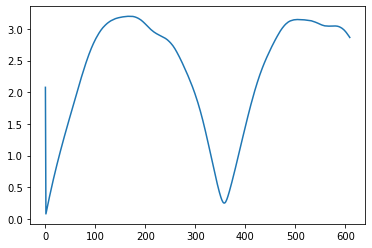

In [73]:
import matplotlib.pyplot as plt
disArr = []
#for i in range(len(val)+len(test)):
  #disArr.append(np.linalg.norm(simulation1[len(X_train)+windowSizeX+i+1]-listOfPredictionsTrue[i]))
for i in range(len(val)):
  disArr.append(np.linalg.norm(postprocess(simulation1[len(X_train)+windowSizeX-1],val)[i]-actualPredictions[i]))

plt.plot(disArr)  

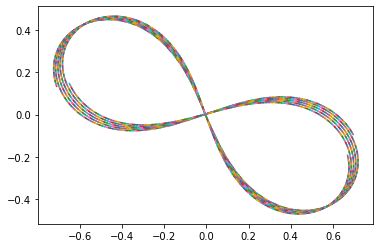

In [65]:
#drawSimulation(simulation1[len(X_train)+windowSizeX+2:len(X_train)+windowSizeX+31])
drawSimulation(simulation1[len(X_train)+windowSizeX-1 : len(X_train)+windowSizeX-1 + len(val)])

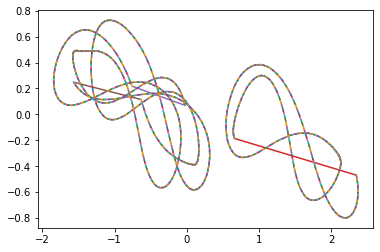

In [72]:
#drawSimulation(listOfPredictionsTrue[1:30])
drawSimulation(actualPredictions)